## Dataset description 

In this competition you will be identifying regions in satellite images that contain certain cloud formations, with label names: Fish, Flower, Gravel, Sugar. For each image in the test set, you must segment the regions of each cloud formation label. Each image has at least one cloud formation, and can possibly contain up to all all four.

#### Files

- train.csv - the run length encoded segmentations for each image-label pair in the train_images
- train_images.zip - folder of training images
- test_images.zip - folder of test images; your task is to predict the segmentations masks of each of the 4 cloud types (labels) for each image.

It is important to notice that images (and masks) are `1400 x 2100`, but predicted masks should be `350 x 525`.

## Классификация облаков

Цель:

Неглубокие облака играют огромную роль в определении климата Земли, но их трудно распознать и классифицировать в климатических моделях. Классифицируя различные типы организации облаков, исследователи из Института Макса Планка надеются улучшить наше физическое понимание этих облаков, что, в свою очередь, поможет нам построить более совершенные климатические модели.
Существует множество способов организации облаков, но границы между различными формами организации нечеткие. Это затрудняет построение традиционных алгоритмов, основанных на правилах, для разделения облачных характеристик. Однако человеческий глаз отлично справляется с обнаружением особенностей - например, облаков, похожих на цветы.
В этом задании вам предстоит построить модель для классификации моделей организации облаков на спутниковых снимках. В случае успеха вы поможете ученым лучше понять, как облака будут определять наш будущий климат.

Описание/Пошаговая инструкция выполнения домашнего задания:

- сформировать нейронную сверточную сеть;
- обучить сеть на представленных данных;
- оценить качество модели. В качестве критерия используйте Dice coefficient.

In [80]:
# !pip install catalyst
# !pip install pretrainedmodels
# !pip install segmentation_models_pytorch
# !pip install pytorch_toolbelt
# !pip install torchvision==0.4

## Importing libraries

In [76]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
#from albumentations import torch as AT

# from catalyst.data import Augmentor
from catalyst import dl, utils
#from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
#from dl.runner import SupervisedRunner
#from catalyst.contrib.models.segmentation import Unet
#from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

## Helper functions and classes

In [85]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Для начала, посмотрим на набор данных

In [15]:
path = 'data/'
os.listdir(path)

['train_images', 'sample_submission.csv', 'train.csv', 'test_images']

We have folders with train and test images, file with train image ids and masks and sample submission.

In [16]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [17]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
 2   label          22184 non-null  object
 3   im_id          22184 non-null  object
dtypes: object(4)
memory usage: 693.4+ KB


In [83]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'Train dataset: {n_train} images ')
print(f'Test dataset : {n_test} images ')

Train dataset: 5546 images 
Test dataset : 3698 images 


In [19]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Image_Label
Fish      5546
Flower    5546
Gravel    5546
Sugar     5546
Name: count, dtype: int64

У нас ~5.5k изображений в train dataset и каждое может иметь до 4-х масок: Fish, Flower, Gravel, Sugar.

In [20]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Image_Label
Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: count, dtype: int64

In [21]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

count
2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

Есть много пустых масок и только 266 изображений содержат все 4

In [82]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

#sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
#sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [53]:
train

Image_Label                                      EncodedPixels  \
0        0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1      0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2      0011165.jpg_Gravel                                                NaN   
3       0011165.jpg_Sugar                                                NaN   
4        002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
...                   ...                                                ...   
22179   ffd6680.jpg_Sugar                                                NaN   
22180    ffea4f4.jpg_Fish                                                NaN   
22181  ffea4f4.jpg_Flower  1194860 675 1196260 675 1197660 675 1199060 67...   
22182  ffea4f4.jpg_Gravel                                                NaN   
22183   ffea4f4.jpg_Sugar                                                NaN   

        label        im_id  
0        Fish  0011165.jpg  
1      Flower  0011165.jpg  
2      Gravel  0011165.jpg  
3       Sugar  0011165.jpg  
4        Fish  002be4f.jpg  
...       ...          ...  
22179   Sugar  ffd6680.jpg  
22180    Fish  ffea4f4.jpg  
22181  Flower  ffea4f4.jpg  
22182  Gravel  ffea4f4.jpg  
22183   Sugar  ffea4f4.jpg  

[22184 rows x 4 columns]

Посмотрим на несколько случайно выбранных изображений и маски

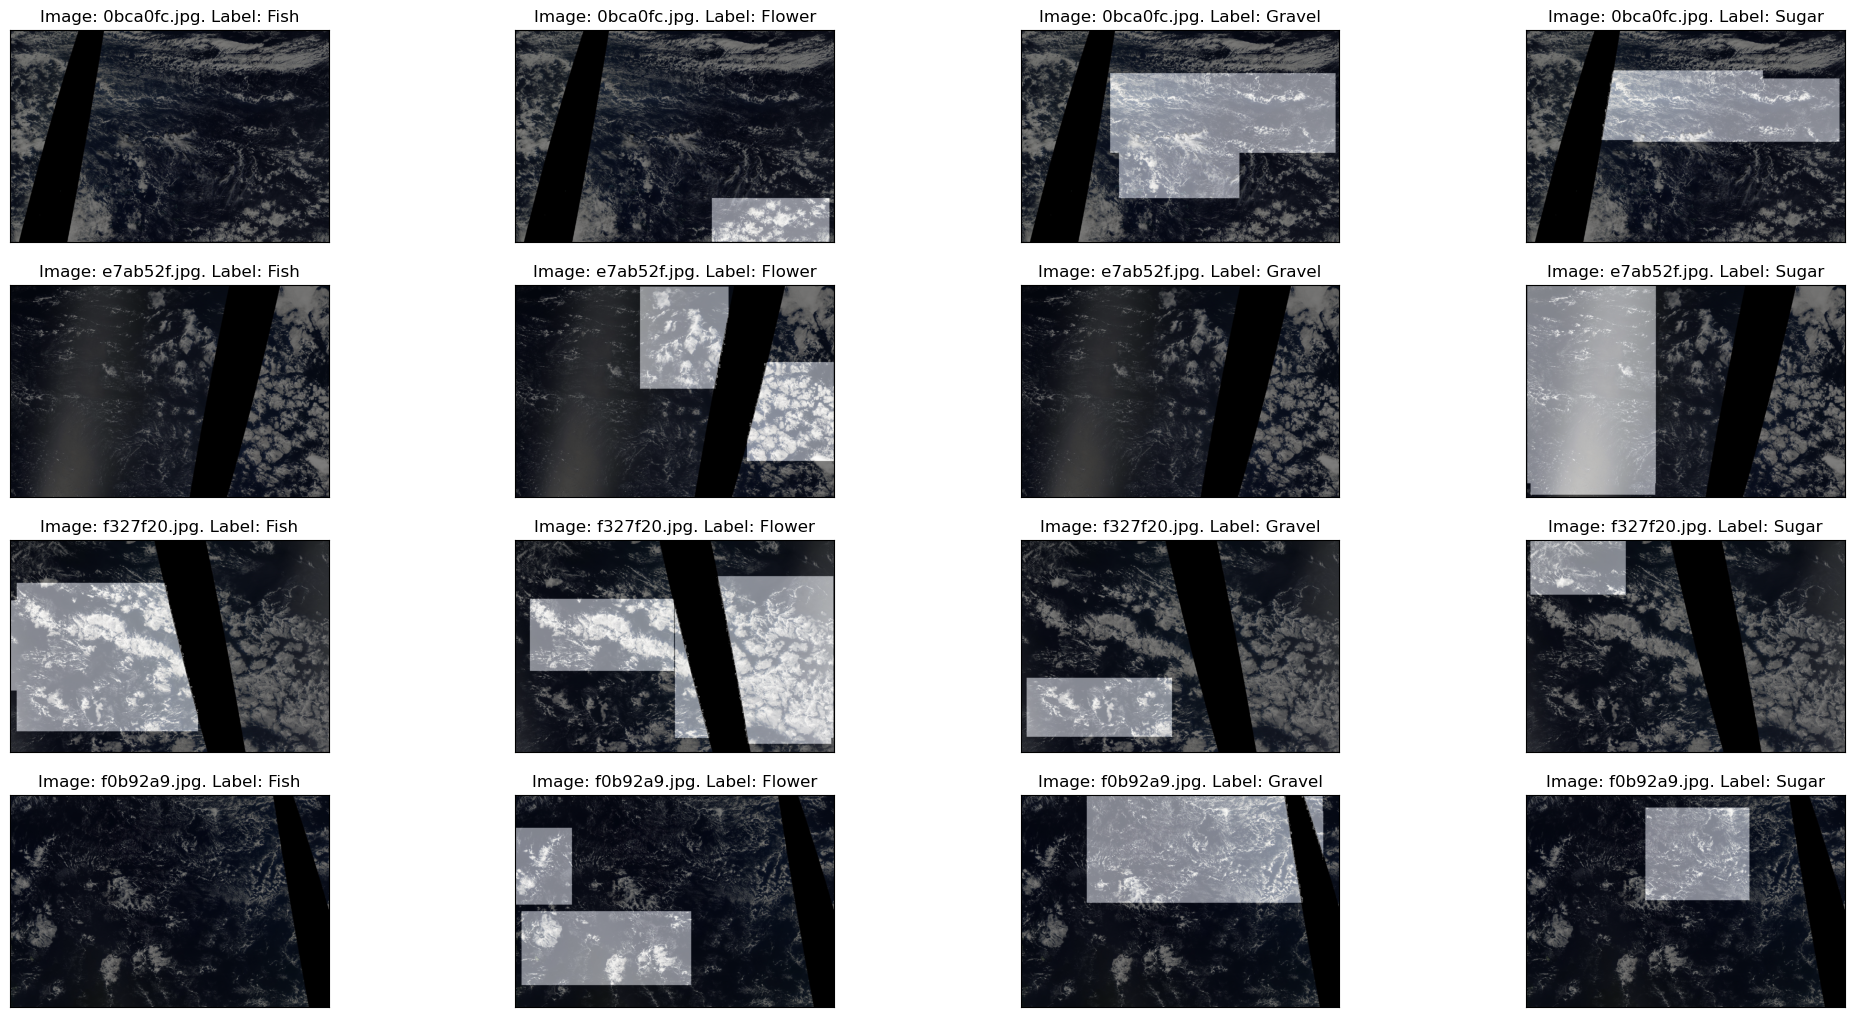

In [26]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

## Preparing data for modelling

Создадим список уникальных имен файлов и посчитаем количество масок - это позволит нам разделить нашу выборку с учетом этого параметра

In [84]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().reset_index().rename(columns={'Image_Label': 'img_id'})

In [52]:
id_mask_count

img_id  count
0     24dd99c.jpg      4
1     562f80a.jpg      4
2     944f10b.jpg      4
3     55b539f.jpg      4
4     cdf7242.jpg      4
...           ...    ...
5541  4cce343.jpg      1
5542  4cd1196.jpg      1
5543  4ce7229.jpg      1
5544  4d07564.jpg      1
5545  ffea4f4.jpg      1

[5546 rows x 2 columns]

In [79]:
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
# test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [78]:
train_ids.shape, valid_ids.shape

((4991,), (555,))

## Setting up data for training

In [ ]:
Для ускорения обучения модели воспользуемся предобученной моделью ResNet50 и фреймворком Catalyst

In [38]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms=albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #augmented = self.transforms(image=img, mask=mask)
        #img = augmented['image']
        #mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

Now we define model and training parameters

In [41]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/vlad/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.7MB/s]


In [77]:
num_workers = 0
bs = 16
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, 
                             transforms = get_training_augmentation(), 
                             preprocessing = get_preprocessing(preprocessing_fn)
                            )
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, 
                             transforms = get_validation_augmentation(), 
                             preprocessing = get_preprocessing(preprocessing_fn)
                            )

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [25]:
num_epochs = 19
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

## Model training

In [26]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/19 * Epoch (train): 100% 312/312 [24:13<00:00,  4.50s/it, _timers/_fps=4.181, dice=0.430, loss=0.853]
0/19 * Epoch (valid): 100% 35/35 [01:04<00:00,  1.68s/it, _timers/_fps=13.906, dice=0.344, loss=1.006]
[2019-09-15 15:13:45,496] 
0/19 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=3.9100 | _timers/batch_time=4.1280 | _timers/data_time=4.1069 | _timers/model_time=0.0209 | dice=0.3799 | loss=0.9770
0/19 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=9.4642 | _timers/batch_time=1.6995 | _timers/data_time=1.6852 | _timers/model_time=0.0142 | dice=0.4367 | loss=0.9654
1/19 * Epoch (train): 100% 312/312 [23:57<00:00,  4.33s/it, _timers/_fps=4.355, dice=0.413, loss=0.929]
1/19 * Epoch (valid): 100% 35/35 [01:02<00:00,  1.67s/it, _timers/_fps=14.107, dice=0.386, loss=0.910]
[2019-09-15 15:38:49,318] 
1/19 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=3.9650 | _timers/batch_time=4.0763 | _timers/data_time=4.05

In [27]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

### Выводы

- BCEDiceLoss последовательно растет и стабилизируется после 12 эпохи обучения, что говорит о достижении баланса пиксельной точности и локализации границ между предсказанными и целевыми значениями масок;
- Функция потерь (loss) снижается и к концу обучения значения для train/val выборки практически совпадают;

Это означает, что в целом наша модель обучилась и может быть использована для задачи сегментации типов облаков.

<img src="base_lr.png" width=1200>
<img src="dice.png" width=1200>
<img src="loss.png" width=1200>